In [1]:
from ctd.task_modeling.model.rnn import GRU_RNN
import matplotlib.pyplot as plt

from ctd.task_modeling.datamodule.task_datamodule import TaskDataModule
from ctd.task_modeling.task_wrapper.task_wrapper import TaskTrainedWrapper
from pytorch_lightning import Trainer
import torch
import numpy as np
import os
import pathlib, pickle
import cloudpickle
from ctd.task_modeling.task_env.center_out_task import RandomTargetCenterOut
from ctd.task_modeling.task_env.center_out_task import RandomTarget
from ctd.task_modeling.model.node import NODE
from motornet.effector import RigidTendonArm26
from ctd.comparison.analysis.tt.tt import Analysis_TT

from motornet.muscle import MujocoHillMuscle

/Users/elizavetaparfenova/PycharmProjects/NeuroMatch-2025/.venv/lib/python3.12/site-packages/lightning_fabric/__init__.py:40: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


In [4]:
# Load saved model and datamodule
# Step 2: Load the trained model (task wrapper that contains the RNN)
#with open(f'{save_dir}/model.pkl', 'rb') as f:
#    task_wrapper = cloudpickle.load(f)
#with open(f'{save_dir}/datamodule_sim.pkl', 'rb') as f:
#    task_datamodule = cloudpickle.load(f)

In [2]:
# Create the analysis object:


task_env = RandomTargetCenterOut(effector=RigidTendonArm26(muscle=MujocoHillMuscle()))
#task_env.set_model(task_wrapper.model)  # this updates input_components properly



IndexError: too many indices for tensor of dimension 4

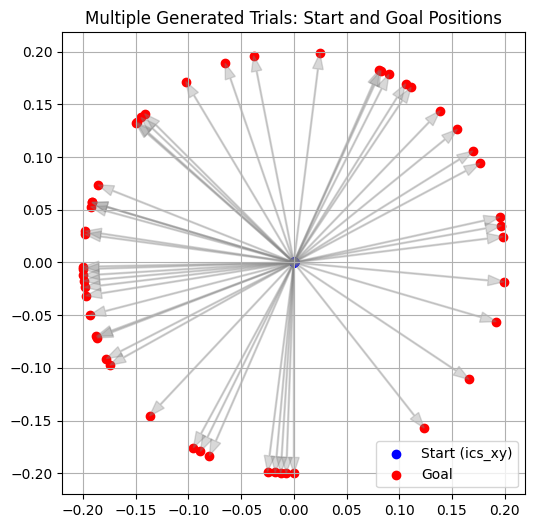

In [3]:
start_positions = []
target_positions = []

for _ in range(50):
    trial_info = task_env.generate_trial_info()  # <-- manually calls generator
    task_env.trial_info = trial_info  # <-- force update if task_env stores it

    start_xy = trial_info['ics_xy'].detach().cpu().numpy().flatten()
    goal = trial_info['goal'].detach().cpu().numpy().flatten()

    start_positions.append(start_xy)
    target_positions.append(goal)

start_positions = np.array(start_positions)
target_positions = np.array(target_positions)

plt.figure(figsize=(6, 6))
plt.scatter(start_positions[:, 0], start_positions[:, 1], color='blue', label='Start (ics_xy)')
plt.scatter(target_positions[:, 0], target_positions[:, 1], color='red', label='Goal')

# Optional: draw arrows from start to goal
for start, goal in zip(start_positions, target_positions):
    plt.arrow(start[0], start[1], goal[0] - start[0], goal[1] - start[1],
              head_width=0.01, alpha=0.3, length_includes_head=True, color='gray')

plt.gca().set_aspect('equal')
plt.title("Multiple Generated Trials: Start and Goal Positions")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Get HOME_DIR from environment variable or fallback to home folder
model_name = 'models_RNN_random_target'

HOME_DIR = os.getenv("HOME_DIR", str(pathlib.Path.home()))

# Create save directory
save_dir = pathlib.Path(HOME_DIR) / model_name
save_dir.mkdir(parents=True, exist_ok=True) 

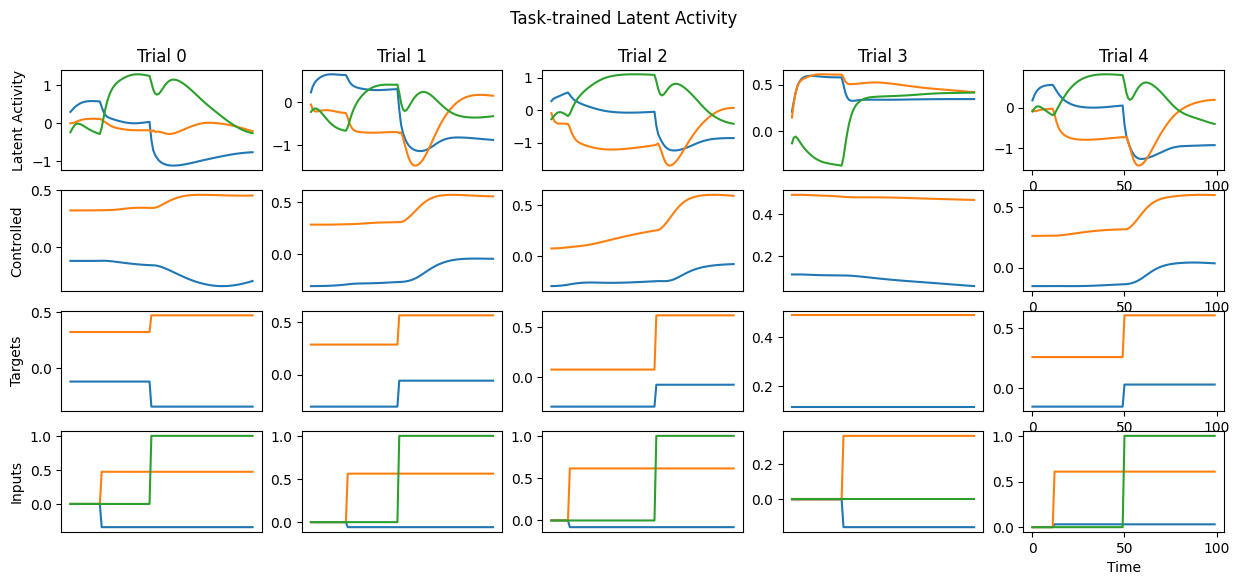

In [3]:
fpath_NODE = HOME_DIR + model_name + '/'
# Create the analysis object:
analysis_NODE_runoptimized = Analysis_TT(
    run_name = "RNN_random-target",
    filepath = fpath_NODE)

analysis_NODE_runoptimized.plot_trial_io(num_trials = 5)

In [8]:
# Load saved model and datamodule

# Step 2: Load the trained model (task wrapper that contains the RNN)
with open(f'{save_dir}/model.pkl', 'rb') as f:
    task_wrapper = pickle.load(f)
with open(f'{save_dir}/datamodule_sim.pkl', 'rb') as f:
    task_datamodule = pickle.load(f)

In [9]:
rttask_env = RandomTargetCenterOut(effector = RigidTendonArm26(muscle = MujocoHillMuscle()))


[DEBUG] ics_joint: shape torch.Size([1, 4])
[DEBUG] goal: shape torch.Size([1, 2])
[DEBUG] phase: shape torch.Size([1, 2])


In [10]:
task_wrapper.eval()
model = task_wrapper.model

rttask_env.set_model(model)


[DEBUG] Model expects input size: 17
[DEBUG] Component sizes: {'ics_joint': 4, 'ics_xy': 2, 'goal': 2, 'context': 8, 'phase': 1}
[INFO] Auto-matched inputs: ['ics_joint', 'ics_xy', 'goal', 'context', 'phase']


In [12]:
print("Action shape:", action.shape)
print("Expected shape:", rttask_env.action_space.shape)


Action shape: (6,)
Expected shape: (6,)


In [24]:
# TESTING
# Reset environment and get initial observation
obs, info = rttask_env.reset()
obs_vector = rttask_env.construct_input_vector(info)  # ensures proper input shape
done = False
trajectory = []

hidden = None  # initialize hidden state

while not done:
    #Feeds the current state into the model and gets the action output.
    input_tensor = obs_vector  # shape: [1, N]

    with torch.no_grad():
        action_tensor, hidden = model(input_tensor, hidden)

    action_tensor = action_tensor[:, :rttask_env.action_space.shape[0]]
    action = action_tensor.cpu().numpy()

    if action.ndim == 1:
        action = action[np.newaxis, :]  # Ensure shape is (1, 6)
    #Ensures the action is shaped like (1, N) to match the environment’s expectations.
    obs, _, done, _, info = rttask_env.step(action)

    # 👇 update the trial_info so construct_input_vector works
    rttask_env.trial_info.update(info)
    obs_vector = rttask_env.construct_input_vector(rttask_env.trial_info)

    trajectory.append({
        'obs': obs_vector.squeeze().detach().cpu().numpy(),
        'action': action.squeeze(),
        'goal': info['goal'].squeeze().cpu().numpy(),
        'fingertip': info['states']['fingertip'].squeeze().cpu().numpy(),
    })



[DEBUG] ics_joint: shape torch.Size([1, 4])
[DEBUG] ics_xy: shape torch.Size([1, 2])
[DEBUG] goal: shape torch.Size([1, 2])
[DEBUG] context: shape torch.Size([1, 8])
[DEBUG] phase: shape torch.Size([1, 8])
[DEBUG] ics_joint: shape torch.Size([1, 4])
[DEBUG] ics_xy: shape torch.Size([1, 2])
[DEBUG] goal: shape torch.Size([1, 2])
[DEBUG] context: shape torch.Size([1, 8])
[DEBUG] phase: shape torch.Size([1, 8])
[DEBUG] ics_joint: shape torch.Size([1, 4])
[DEBUG] ics_xy: shape torch.Size([1, 2])
[DEBUG] goal: shape torch.Size([1, 2])
[DEBUG] context: shape torch.Size([1, 8])
[DEBUG] phase: shape torch.Size([1, 8])
[DEBUG] ics_joint: shape torch.Size([1, 4])
[DEBUG] ics_xy: shape torch.Size([1, 2])
[DEBUG] goal: shape torch.Size([1, 2])
[DEBUG] context: shape torch.Size([1, 8])
[DEBUG] phase: shape torch.Size([1, 8])
[DEBUG] ics_joint: shape torch.Size([1, 4])
[DEBUG] ics_xy: shape torch.Size([1, 2])
[DEBUG] goal: shape torch.Size([1, 2])
[DEBUG] context: shape torch.Size([1, 8])
[DEBUG] ph

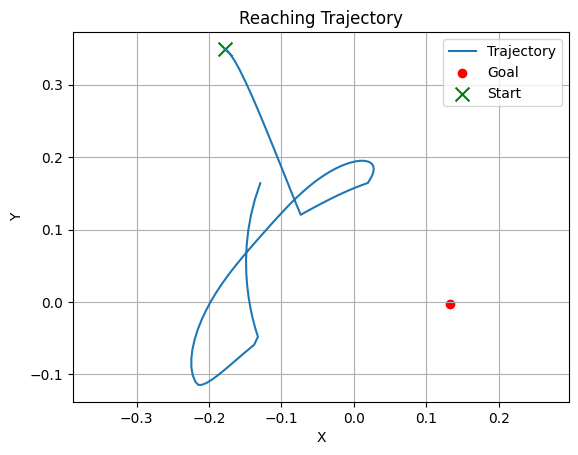

In [26]:
import matplotlib.pyplot as plt
fingertips = np.array([step['fingertip'] for step in trajectory])
goal = trajectory[0]['goal']
start = fingertips[0]

plt.plot(fingertips[:, 0], fingertips[:, 1], label='Trajectory')
plt.scatter(goal[0], goal[1], color='red', label='Goal')
plt.scatter(start[0], start[1], color='green', label='Start', marker='x', s=100)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Reaching Trajectory')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()



In [28]:
obs_vector, trial_info = rttask_env.reset()
print("Goal:", trial_info['goal'])
print("Start label (ics_xy):", trial_info['ics_xy'])

# Now check the *real* fingertip location
print("Actual start (fingertip):", trial_info['states']['fingertip'])


[DEBUG] ics_joint: shape torch.Size([1, 4])
[DEBUG] ics_xy: shape torch.Size([1, 2])
[DEBUG] goal: shape torch.Size([1, 2])
[DEBUG] context: shape torch.Size([1, 8])
[DEBUG] phase: shape torch.Size([1, 8])
Goal: tensor([[-0.1247,  0.1563]])
Start label (ics_xy): tensor([[0., 0.]])


KeyError: 'states'

In [31]:
angs = rttask_env.current_trial["ics_joint"]
geometry = rttask_env.effector.get_geometry(angs)
print("True starting fingertip:", geometry["fingertip"])




AttributeError: 'RandomTargetCenterOut' object has no attribute 'current_trial'

In [44]:
trainer.fit(task_wrapper, task_datamodule)
results = task_wrapper.simulate(rt_task_env, n_trials=10)


  | Name  | Type      | Params
------------------------------------
0 | model | NODE_CUDA | 97.1 K
------------------------------------
97.1 K    Trainable params
0         Non-trainable params
97.1 K    Total params
0.389     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


AttributeError: 'TaskTrainedWrapper' object has no attribute 'simulate'

In [3]:
# Step 1 ONLY WHILE TRAINING: Instantiate the model
#rnn = GRU_RNN(latent_size = 128) # Look in ctd/task_modeling/models for alternative choices!

# Step 2: Instantiate the task environment
task_env = rt_task_env

# Step 3: Instantiate the task datamodule
task_datamodule = TaskDataModule(task_env, n_samples = 1000, batch_size = 256)

# Step 4: Instantiate the task wrapper
task_wrapper = task_wrapper

# Step 5 ONLY WHILE TRAINING: Initialize the model with the input and output sizes
#rnn.init_model(
#    input_size = task_env.observation_space.shape[0] + task_env.context_inputs.shape[0],
#    output_size = task_env.action_space.shape[0]
#    )

# Step 6:  Set the environment and model in the task wrapper
task_wrapper.set_environment(task_env)
# only when training
#task_wrapper.set_model(rnn)

# Step 7 ONLY WHILE TRAINING: Define the PyTorch Lightning Trainer object (put `enable_progress_bar=True` to observe training progress)
trainer = Trainer(accelerator= "cpu",max_epochs=10,enable_progress_bar=True)

# Step 8 ONLY WHILE TRAINING: Fit the model
trainer.fit(task_wrapper, task_datamodule)

/Users/elizavetaparfenova/PycharmProjects/NeuroMatch-2025/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'data_env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['data_env'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/elizavetaparfenova/PycharmProjects/NeuroMatch-2025/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name     | Type                  | Params
---------------------------------------------------
0 | task_env | RandomTargetCenterOut | 84    
1 | model    | GRU_RNN               | 57.4 K
---------------------------------------------------
57.4 K    Trainable params
84        Non-trainable params
57.4 K    To

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/elizavetaparfenova/PycharmProjects/NeuroMatch-2025/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/elizavetaparfenova/PycharmProjects/NeuroMatch-2025/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/elizavetaparfenova/PycharmProjects/NeuroMatch-2025/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

NaN or Inf found in input tensor.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
results = task_wrapper.simulate(rt_task_env, n_trials=10)

In [7]:
import matplotlib.pyplot as plt
import torch

# Reset environment
obs = task_env.reset()
trajectory = []

# Run one trial with the trained model
for _ in range(task_env.max_steps):
    with torch.no_grad():
        # Combine obs and context if needed
        full_obs = torch.cat([obs, task_env.context_inputs], dim=-1)
        action = rnn(full_obs.unsqueeze(0)).squeeze(0)
    obs = task_env.step(action)
    
    # Save for plotting
    trajectory.append({
        "target": task_env.target.clone().detach().cpu(),
        "action": action.clone().detach().cpu(),
    })

# Plot target over time
targets = torch.stack([step["target"] for step in trajectory])
plt.plot(targets[:, 0], label="Target X")
plt.plot(targets[:, 1], label="Target Y")
plt.xlabel("Time step")
plt.ylabel("Target value")
plt.title("Target Trajectory Over Time")
plt.legend()
plt.grid(True)
plt.show()


AttributeError: 'RandomTargetCenterOut' object has no attribute 'max_steps'

In [51]:
import pathlib, pickle
import os
HOME_DIR = os.getenv("HOME_DIR")
# Create a save directory
save_dir = pathlib.Path(HOME_DIR) / "models_GRU_center_out"
save_dir.mkdir(exist_ok=True)

# a) Save the trained TaskTrainedWrapper (includes GRU_RNN)
with open(save_dir / "model.pkl", "wb") as f:
    pickle.dump(task_wrapper, f)

# b) Save the TaskDataModule
with open(save_dir / "datamodule_sim.pkl", "wb") as f:
    pickle.dump(task_datamodule, f)

print("In", save_dir)

Saved everything to ComputationThruDynamicsBenchmark/models_GRU_center_out


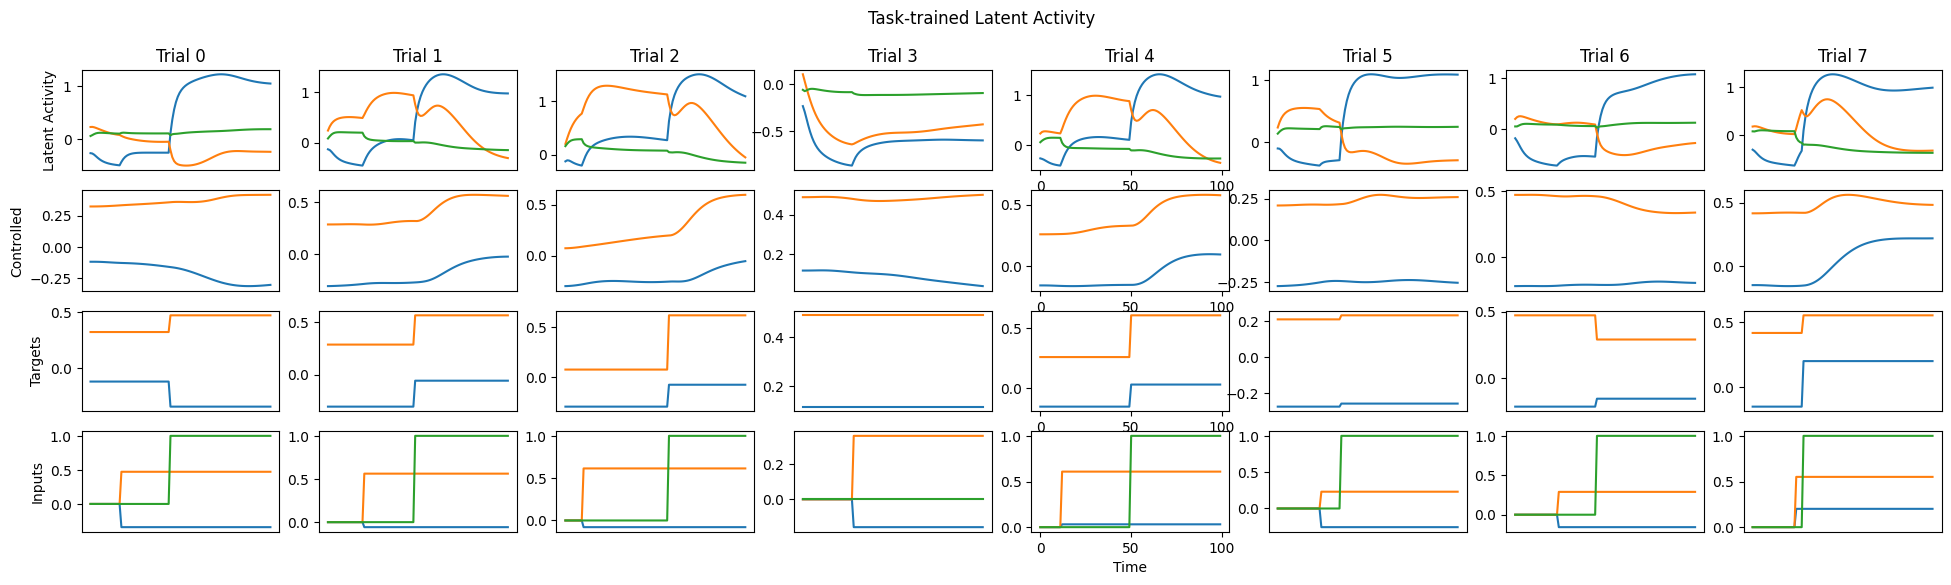

In [3]:
import os
HOME_DIR = os.getenv("HOME_DIR")
from ctd.comparison.analysis.tt.tt import Analysis_TT
fpath_NODE = HOME_DIR + "models_GRU_center_out/"  # optimized run of NODE model using Optuna
# Create the analysis object:
analysis_NODE_runoptimized = Analysis_TT(
    run_name = "GRU_center_out_3bff",
    filepath = fpath_NODE)

analysis_NODE_runoptimized.plot_trial_io(num_trials = 8)

In [ ]:
# re-run to see generation og targets
